## Решение соревнования https://www.kaggle.com/c/dmia-surnames-classification
##### Нужно построить классификатор, определяющий, является ли слово фамилией. Для оценки качества используется площадь под ROC-кривой (AUC), так как классы сильно несбалансированны.
#### Тушин Кирилл Public - 0.98745 Private - 0.98728

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score , StratifiedKFold

import pymorphy2
import pymystem3
from natasha import NamesExtractor
from sklearn.preprocessing import LabelEncoder
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc="apply")

%matplotlib inline

/home/kirill/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def validate(x , y):
    model = LGBMClassifier(n_estimators=670 ,learning_rate=0.09 , num_leaves=53 , subsample=0.9 , subsample_for_bin=60000 , min_child_samples = 10 , random_state = 42)
    cv = StratifiedKFold(4 ,shuffle=True, random_state=99)
    score = cross_val_score(model , x , y , scoring='roc_auc' , cv=cv)
    return score.mean() , score.std()

# Подготовка

### Загружаем данные

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
all_data = pd.concat([train , test])

sample = pd.read_csv('data/sample_submission.csv')

### Гласные , согласные , алфавит , популярные окончания фамилий

In [4]:
volwes = 'аеёиоуыэюя'
consonant = 'бвгджзйклмнпрстфхцчшщъьа'
alphabet = set(volwes) | set(consonant)

good_ends = ['цкий',  'ский', 'цкая', 'ская',
             'нен', 'ына', 'ина', 'ёва', 'ева', 'ова',
             'ым',  'на', 'ых', 'их', 'ын', 'ин', 'ёв', 'ев', 'ов']

### Получаем список всех символов в tarin & test
### Получаем список плохих символов (символы которые не встречаются в алфавите)

In [5]:
def symbols(sentence , n):
    res = []
    for s in sentence:
        res.extend(list(s.lower()))
    return set(res)


all_symbols = symbols(all_data.Word.values , 1)
bad_symbols = all_symbols ^ alphabet

# Признаки

### Есть ли дупликаты у слова

In [6]:
all_data['is_duplicate'] = all_data['Word'].duplicated(keep=False).astype('int8')

### Количество гласных , согласных , отношение глассных к согласным, количество плохих символов, хорошее ли окончание

In [7]:
def vowels_count(x):
    return len([s for s in x.lower() if s in volwes])

def consonant_count(x):
    return len([s for s in x.lower() if s in consonant])

def divide_vov_by_cons(x):
    return vowels_count(x)/(consonant_count(x) + 0.001)

def bad_count(x):
    return len([s for s in x.lower() if s in bad_symbols])

def have_good_end(x):
    if (x[-2:] in good_ends) or (x[-3:] in good_ends) or (x[-4:] in good_ends):
        return 1
    return 0

func = [str.isupper , str.istitle , len , vowels_count , consonant_count, divide_vov_by_cons, bad_count , have_good_end]
columns = ['isupper' , 'istitle' , 'len' , 'vowels_count' , 'consonant_count' , 'divide_vov_by_cons' ,'bad_count' , 'have_good_end']
for f ,col in tqdm_notebook(zip(func, columns) , total = len(func)):
    all_data[col] = all_data['Word'].apply(f).astype('int8')

### Смотрим в каждом слове есть ли конкретное окончание из good_ends
### Количество каждой буквы алфавита

In [8]:
for s in tqdm_notebook(good_ends):
    all_data['last_' + s] = all_data['Word'].apply(lambda x: x[-len(s):].lower() == s).astype('int8')

for s in tqdm_notebook(alphabet):
    all_data['count_' + s] = all_data['Word'].apply(lambda x: x.lower().count(s)).astype('int8')

### Валидируемся

In [9]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word' ] , axis=1) , new_train['Label'])

(0.9382254897975424, 0.0011649971071928608)

### Вычисляем какая буква стоит на 0, 1, 2, 3 месте
### Далее переворачиваем слово и делаем тоже самое , то есть идем с конца
### Тоже самое для пар букв , только диапазон мест теперь 0, 1, 2, 3, 4, 5
### Диапазоны искались по валидации ; для троек букв валидация не увеличивалась

In [10]:
n_of_gramms = [1,2] 
index_smoof = [4,6]
for j , n in tqdm_notebook(zip(n_of_gramms , index_smoof) , total=len(n_of_gramms)):
    for i in range(n):
        col_forward = 'forward_' +str(j) + '_' + str(i)
        all_data[col_forward] = all_data['Word'].apply(str.lower).apply(lambda x: x[i:i+j] if len(x) > i + j - 1 else 'nan')
        all_data[col_forward] = LabelEncoder().fit_transform(all_data[col_forward])

        col_reverse = 'reverse_' +str(j) + '_' + str(i)
        all_data[col_reverse] = all_data['Word'].apply(str.lower).apply(lambda x: x[::-1][i:i+j]  if len(x) > i + j - 1 else 'nan')
        all_data[col_reverse] = LabelEncoder().fit_transform(all_data[col_reverse])

### Валидируемся

In [11]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word' ] , axis=1) , new_train['Label'])

(0.9584048267673966, 0.000951912386237917)

## pymorphy
### Очень много всего , используем почти все возможности pymorphy
### Получаем признаки и делаем LabelEncoder (далее везде где не числовые признаки делаем его)
### Интересно то , что признак 'pymorphy' (просто первый tag слова) дал очень хороший прирост

In [12]:
morph = pymorphy2.MorphAnalyzer()

def name_score(word):
    for p in morph.parse(word):
        if 'Name' in p.tag:
            return p.score
    return 0

def surn_score(word):
    for p in morph.parse(word):
        if 'Surn' in p.tag:
            return p.score
    return 0

all_data['pymorphy_word_is_known'] = all_data['Word'].apply(morph.word_is_known).astype('int8')
all_data['pymorphy_count_in_tag'] = all_data['Word'].apply(lambda x: len(morph.tag(x))).astype('int8')
all_data['pymorphy_score'] = all_data['Word'].apply(lambda x: morph.parse(x)[0].score)
all_data['pymorphy'] = all_data['Word'].apply(lambda x: morph.tag(x)[0])

all_data['pymorphy_animacy'] = all_data['pymorphy'].apply(lambda x: x.animacy)
all_data['pymorphy_POS'] = all_data['pymorphy'].apply(lambda x: x.POS)
all_data['pymorphy_case'] = all_data['pymorphy'].apply(lambda x: x.case)
all_data['pymorphy_number'] = all_data['pymorphy'].apply(lambda x: x.number)
all_data['pymorphy_gender'] = all_data['pymorphy'].apply(lambda x: x.gender)

all_data['pymorphy_name_score'] = all_data['Word'].apply(name_score)
all_data['pymorphy_surn_score'] = all_data['Word'].apply(surn_score)

columns_to_one_hot = ['pymorphy' , 'pymorphy_animacy', 'pymorphy_POS', 'pymorphy_case','pymorphy_number', 'pymorphy_gender']

for col in columns_to_one_hot:
    all_data[col] = LabelEncoder().fit_transform(list(all_data[col].fillna('nan')))

### Валидируемся

In [13]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word' ] , axis=1) , new_train['Label'])

(0.9773451137467059, 0.00041938516789201375)

## pymystem
### Тоже берем много признаков : часть речи , пол , одушевленность ,  и другие
###### Можно переделать гавнокод , когда функция создается в цикле , но руки не дошли

In [14]:
%%time
mystem = pymystem3.Mystem()

part_of_speech = ['A' , 'ADV' , 'ANUM' , 'APRO' , 'COM' , 'CONJ' , 'INTJ' ,
                  'NUM' , 'PART' , 'PR' , 'S' , 'SPRO' , 'V']
gender = ['муж' , 'жен' , 'сред']
anim = ['неод' , 'од']
other = ['вводн' , 'гео' , 'затр' , 'имя' , 'искаж' , 'мж' , 'обсц' , 'отч' ,
         'прдк' , 'разг' , 'редк', 'сокр' , 'устар' , 'фам']

all_gramems = [part_of_speech , gender , anim , other]
str_gramems = ['part_of_speech' , 'gender' , 'anim' , 'other']

for gramem , col in tqdm_notebook(zip(all_gramems, str_gramems) , total = len(all_gramems)):
    # гавнокод
    def func(word):
        try:
            for gr in gramem:
                if mystem.analyze(word)[0]['analysis'][0]['gr'].find(gr) > -1:
                    return gr
        except:
            return 'nan'
        return 'nan'
    
    new_col = 'pymystem_' + col
    all_data[new_col] = all_data['Word'].progress_apply(func)
    all_data[new_col] = LabelEncoder().fit_transform(all_data[new_col].fillna('nan'))


CPU times: user 2min 13s, sys: 27.9 s, total: 2min 41s
Wall time: 5min 35s


### Валидируемся

In [15]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word'] , axis=1) , new_train['Label'])

(0.9787280767542363, 0.0005544518390071671)

### Как признак также добавим gramem (аналогично как в pymorphy tag)
###### Когда уже потратил последний сабмит , заметил что результат на валидации немного ухудшился, и смысла использовать этот признак нет

In [16]:
%%time
def func(word):
    try:
        return mystem.analyze(word)[0]['analysis'][0]['gr']
    except:
        return 'nan'

all_data['pymystem_gr'] = all_data['Word'].progress_apply(func)
all_data['pymystem_gr'] = LabelEncoder().fit_transform(list(all_data['pymystem_gr'].fillna('nan')))


CPU times: user 8.54 s, sys: 1.41 s, total: 9.95 s
Wall time: 16.4 s


### Валидируемся

In [17]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word'] , axis=1) , new_train['Label'])

(0.9786777064965978, 0.0005113228516911118)

## natasha
### Только один признак оказался полезным

In [18]:
%%time
func = NamesExtractor()
def function_natasha(word):
    return 1 if func(word) else 0

all_data['natasha_person'] = all_data['Word'].progress_apply(function_natasha).astype('int8')


CPU times: user 4min 5s, sys: 1 s, total: 4min 6s
Wall time: 4min 5s


### Валидируемся

In [19]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word' ] , axis=1) , new_train['Label'])

(0.9792579567573368, 0.000595159790355668)

## n-grams  - количество кажой в слове
### подготовил хорошие n-grams , обучился на всех и выбрал лучшие иcпользуя отсечение по порогу np.where(model.feature_importances_ > 15)
###### код убрал , потому что там гавнокод)

In [20]:
good_n_grams =['об', 'сб', 'кс', 'им', 'ич', 'ок', 'ву', 'ию', 'ие', 'эк', 'св',
               'бе', 'сп', 'ые', 'ия', 'мм', 'уп', 'ты', 'рр', 'уш', 'эн', 'рт',
               'ур', 'ах', 'ан', 'са', 'ре', 'сн', 'ад', 'ей', 'нд', 'эй', 'же',
               'юк', 'ло', 'ар', 'вс', 'ск', 'ме', 'бу', 'ши', 'ле', 'нв', 'дд',
               'уй', 'ер', 'во', 'ий', 'ед', 'ян', 'рл', 'иг', 'лэ', 'ни', 'рк',
               'вк', 'ну', 'ел', 'вн', 'лс', 'се', 'йе', 'оп', 'ов', 'аб', 'ва',
               'ен', 'ес', 'рн', 'тт', 'ол', 'шк', 'пи', 'вы', 'мп', 'ки', 'тк',
               'су', 'да', 'ал', 'ве', 'ин', 'нк', 'тн', 'рс', 'ст', 'ке', 'дс',
               'ку', 'лл', 'ри', 'нь', 'ик', 'сл', 'си', 'пп', 'де', 'ох', 'из',
               'ях', 'оу', 'ма', 'ем', 'рд', 'нс', 'ам', 'зк', 'но', 'аж', 'рх',
               'ак', 'чк', 'ра', 'ай', 'йл', 'од', 'хо', 'ти', 'по', 'за', 'ос',
               'еч', 'сс', 'йт', 'рь', 'мл', 'га', 'бл', 'ии', 'ит', 'ег', 'ми',
               'он', 'пр', 'ау', 'та', 'ко', 'ев', 'ро', 'уб', 'со', 'ек', 'кт',
               'тр', 'бо', 'ой', 'ор', 'фо', 'ка', 'го', 'ци', 'ль', 'ат', 'ви',
               'лд', 'бр', 'ил', 'ом', 'ул', 'мс', 'ыв', 'нг', 'йн', 'вь', 'дж',
               'ба', 'зу', 'ова', 'афф', 'лад', 'вск', 'олл', 'ови', 'сен', 'ете',
               'ове', 'еру', 'омо', 'вис', 'ерв', 'иль', 'аме', 'лве', 'тис',
               'нас', 'еву', 'ову', 'ров', 'еро', 'мма', 'лья', 'ожн', 'оны',
               'лиф', 'ера', 'мэн', 'рин', 'бер', 'арк', 'ост', 'ния', 'енд',
               'овы', 'пер', 'ний', 'ари', 'тче', 'ном', 'ние', 'енс', 'сон',
               'рук', 'усо', 'вой', 'чик', 'оло', 'еди', 'тво', 'орт', 'ган',
               'энт', 'тор', 'ван', 'нин', 'лон', 'кси', 'ник', 'рид', 'иас',
               'нкл', 'сме', 'ару', 'сла', 'ени', 'сть', 'мон', 'етр', 'ран',
               'нде', 'одо', 'езд', 'нче', 'тер', 'лер', 'ция', 'руж', 'нок',
               'ика', 'лка', 'апе', 'бра', 'лли', 'лик', 'арп', 'ерс', 'тон',
               'ней', 'дер', 'вер', 'дле', 'рик', 'ино', 'лог', 'инс', 'ман',
               'кин', 'вле', 'лет', 'кат', 'жен', 'мет', 'ден', 'арт', 'ины',
               'аля', 'апп', 'нар', 'мор', 'ств']

for s in tqdm_notebook(good_n_grams):
    all_data['count_' + s] = all_data['Word'].apply(lambda x: x.lower().count(s)).astype('int8')

### Валидируемся

In [21]:
new_train = all_data[all_data['Label'].notnull()]
validate(new_train.drop(['Label' , 'Word' ] , axis=1) , new_train['Label'])

(0.9807580908449329, 0.0005487270893357827)

### Итого 377 признаков

In [22]:
new_train = all_data[all_data['Label'].notnull()]
new_test = all_data[all_data['Label'].isnull()]

new_train.to_csv('new_train.csv' , index=False)
new_test.to_csv('new_test.csv' , index=False)

## Заметим лик
##### Если посмотреть на пересечение train & test , сгрупировав данные по mean(). Заметим что в пересечении участвуют только строки у которых среднее значение либо 0 либо 1. Но в train присутсвуют одинаковые слова с разными Label , их среднее 0.5 . Сделано предположение, что у строк , которые в пересечении тоже должно быть среднее значение 0.5 . Поэтому выставляем в них Label наоборот, иначе чем в train .

In [23]:
new_train = all_data[all_data['Label'].notnull()]
new_test = all_data[all_data['Label'].isnull()]
# ищем пересечение train & test
new_test.drop('Label' , axis=1 , inplace=True)
new_test = pd.merge(new_test , new_train[['Label' , 'Word']].groupby('Word' , as_index=False).mean() , on=['Word'] , how='left')

model = LGBMClassifier(n_estimators=670 ,learning_rate=0.09 , num_leaves=53 , subsample=0.9 , subsample_for_bin=60000 , min_child_samples = 10 , random_state = 42)
model.fit(new_train.drop(['Label' , 'Word'] , axis=1) , new_train['Label'])
sample['Prediction'] = model.predict_proba(new_test.drop(['Word' , 'Label'] , axis=1))[:,1]

# выставляем в prediction другой Label чем в train
sample['in_train_label'] = new_test['Label']
sample.loc[sample.in_train_label == 0 , 'Prediction'] = 1
sample.loc[sample.in_train_label == 1 , 'Prediction'] = 0
sample.drop('in_train_label' , axis=1 , inplace=True)

sample.to_csv('submit.csv' , index=False)

/home/kirill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Plot feature importances

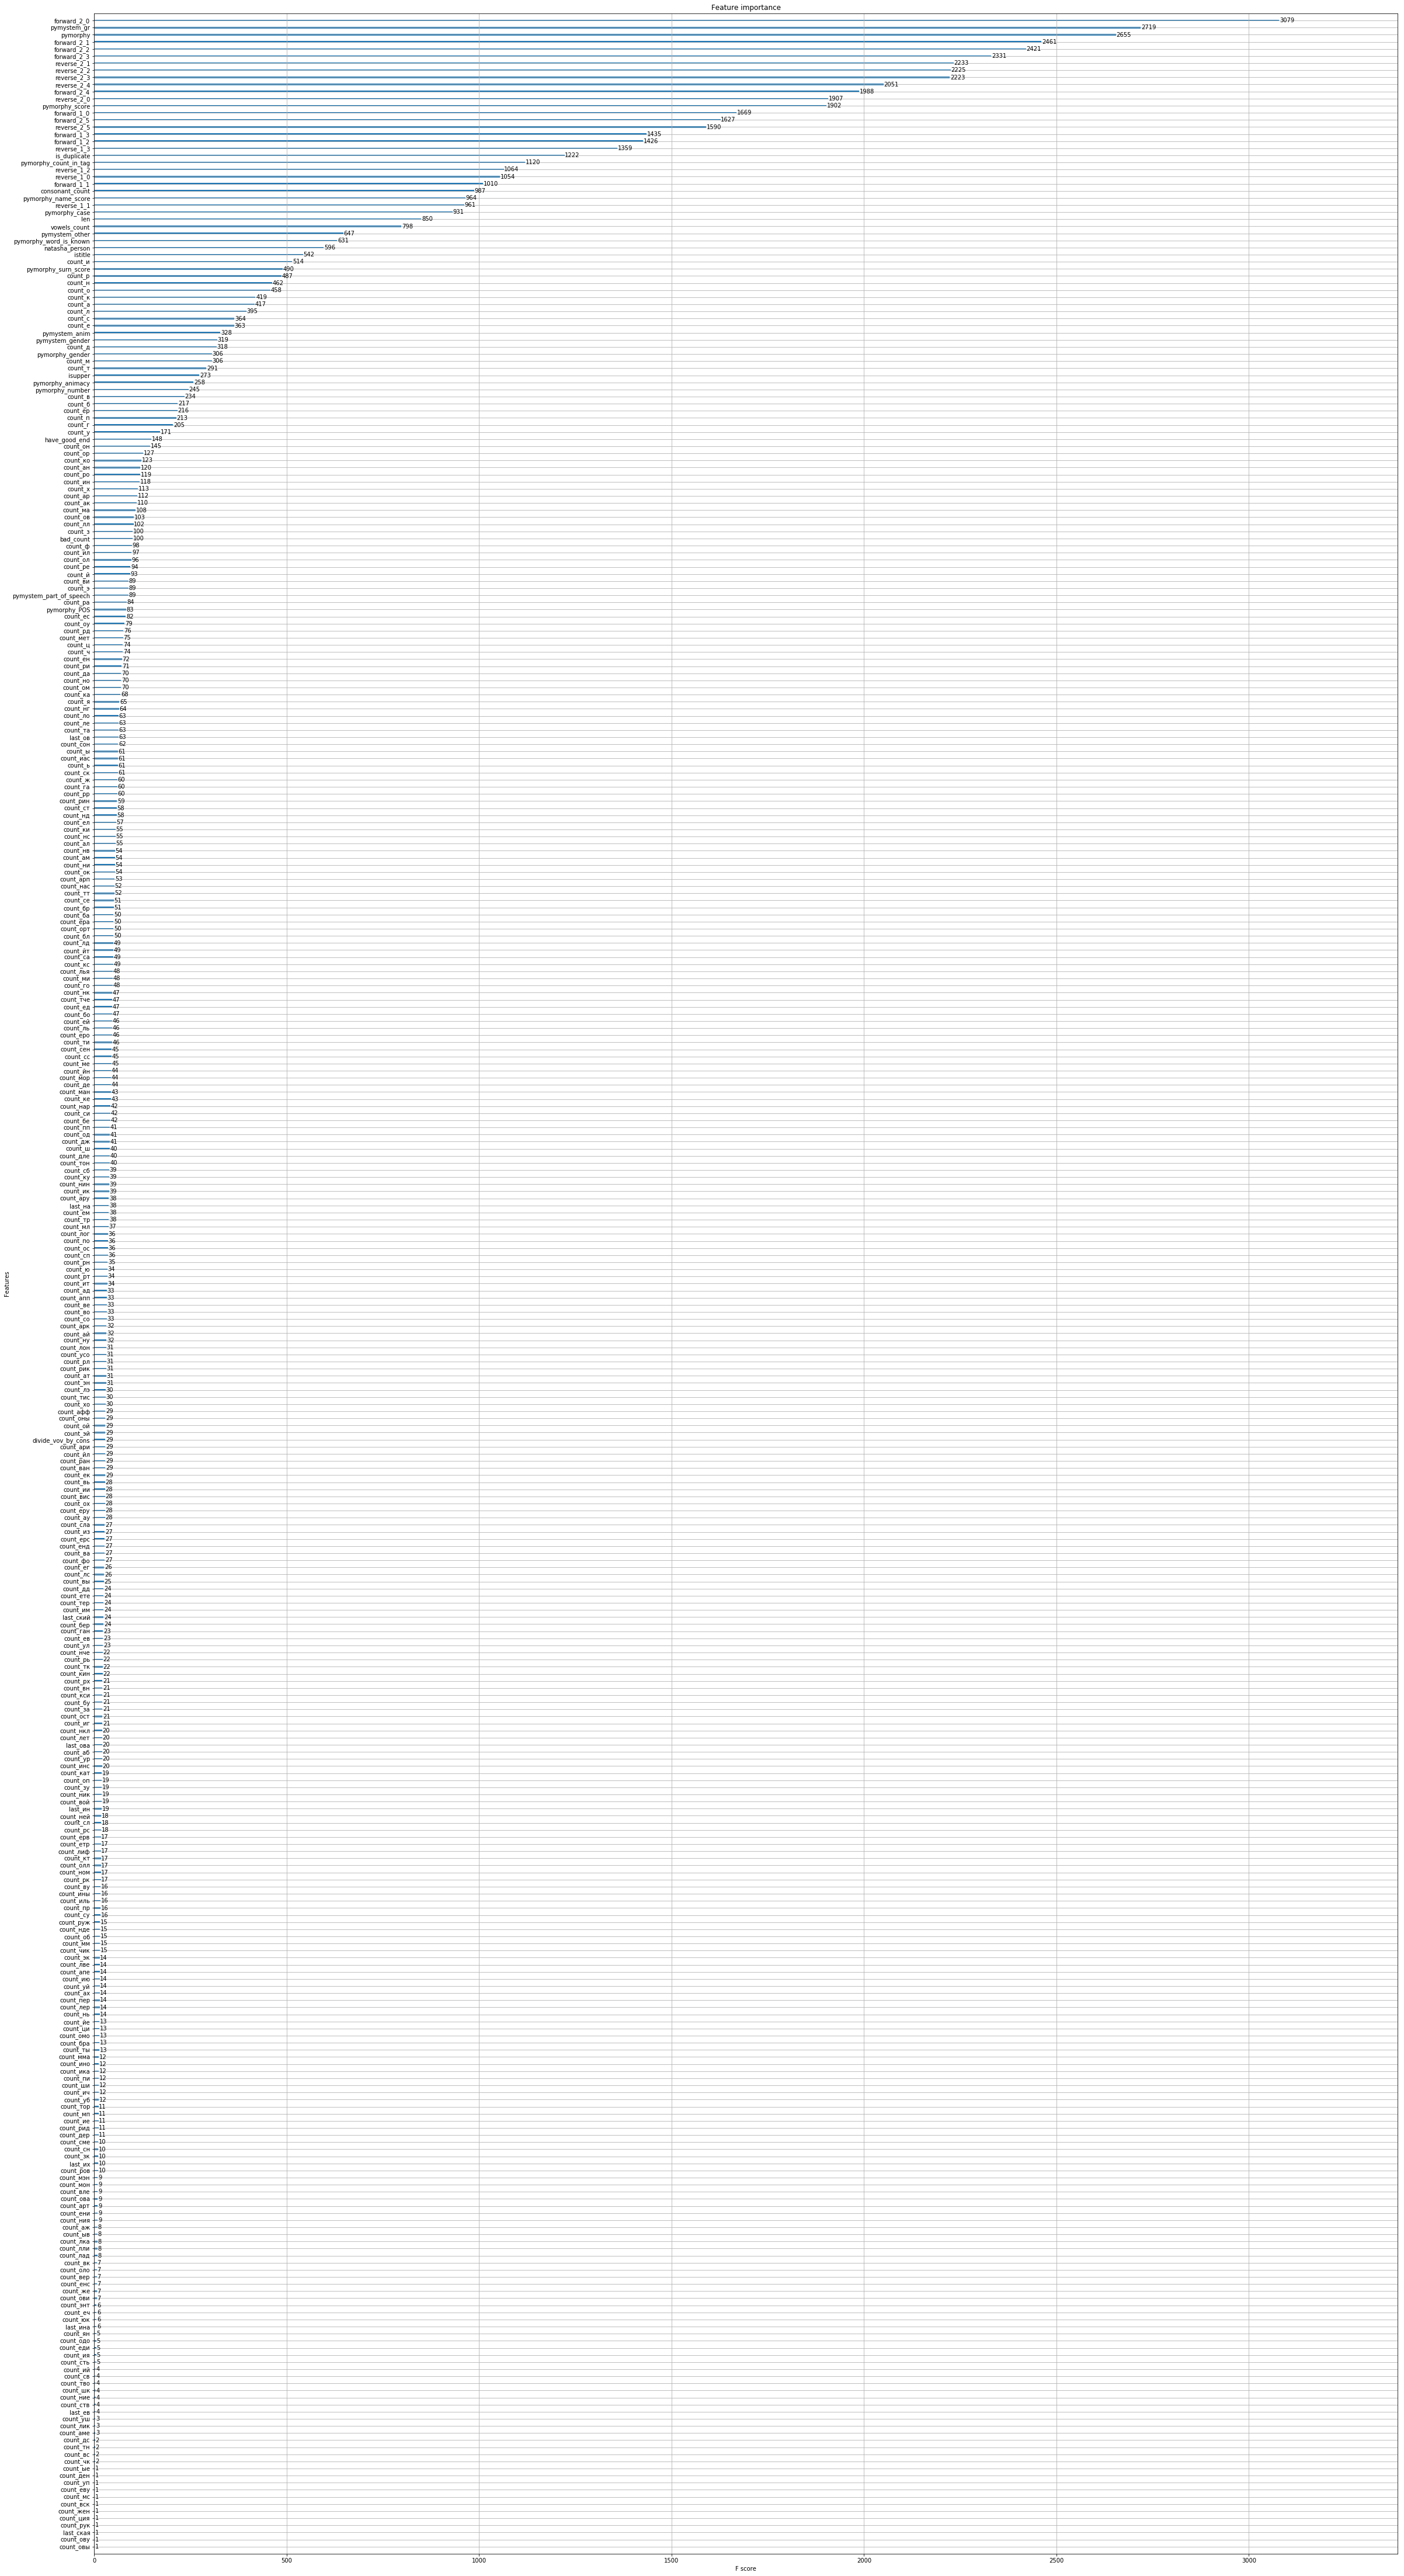

In [24]:
def my_plot_importance(booster, figsize, **kwargs):
    from xgboost import plot_importance
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

model = XGBClassifier(max_depth = 10 , n_estimators=670 , learning_rate=0.09 , colsample_bytree=0.9 , colsample_bylevel=0.6)
model.fit(new_train.drop(['Label' , 'Word'] , axis=1)  , new_train['Label'])
my_plot_importance(model , (40,80))

## Что можно было сделать еще
###### Лик : Длина слов - в train не содержится слов с Label 1 , длиной больше 18. Можно было это использовать , но я это сделал криво один раз и забил.
###### Использовать библиотеки spacy , tomita-parser
###### Wor2Vec - на буквах , на пар букв , на тройке букв,  у меня почему то не зашло
###### tf_idf , у меня тоже не зашло